In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x +5

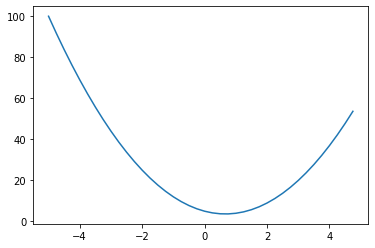

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
h = 0.000000000001
x = 0.66666
# derivative formula
(f(x+h) - f(x))/h

0.0004440892098500626

In [5]:
h = 0.0001
a = 2.
b = -2.
c = 10.0
d1 = a*b +c
b += h
d2 = a*b +c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

# a 6 b -2 c 1

d1 6.0
d2 6.0001999999999995
slope 1.9999999999953388


In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._op = _op
        self._prev = set(_children)
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        l = f'[{self.label}] ' if self.label else ''
        return l + f'v(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        print('mul',self, other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other **-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # int or float only
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * out.grad * (self.data**(other-1))
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        # list of nodes in topological order
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        topo.reverse()
        self.grad = 1.0
        for n in topo:
            n._backward()

In [7]:
a = Value(data=1.3); a.label = 'a'
b = Value(data=2); b.label = 'b'
print(a,b)
print('a/b =', a / b)
print('a**-1 =', a**-1)


print(2 + a)
print(a + 3)
print(a.exp())

print('a-b',a-b)

[a] v(data=1.3) [b] v(data=2)
mul [a] v(data=1.3) v(data=0.5)
a/b = v(data=0.65)
a**-1 = v(data=0.7692307692307692)
v(data=3.3)
v(data=4.3)
v(data=3.6692966676192444)
mul [b] v(data=2) v(data=-1)
a-b v(data=-0.7)


In [8]:
math.exp(1)

2.718281828459045

In [9]:
a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10.0, label='c')
e  = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


mul [a] v(data=2.0) [b] v(data=-3)
mul [d] v(data=4.0) [f] v(data=-2.0)


[L] v(data=-8.0)

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, 
                 label='{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad),
                 shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        e1 = str(id(n1))
        e2 = str(id(n2)) + n2._op
        dot.edge(e1, e2)
    return dot
    

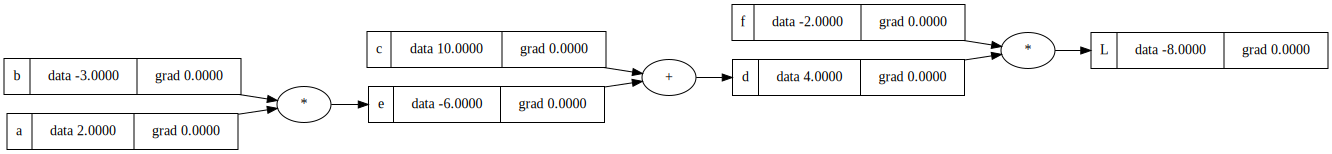

In [11]:
draw_dot(L)


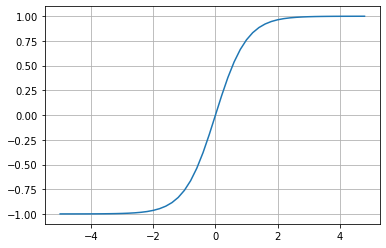

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)) ); plt.grid()


In [13]:
# neurone like expression:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.881373, label='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# output
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1) / (e +1)
o.label = 'o'

mul [x1] v(data=2.0) [w1] v(data=-3.0)
mul [x2] v(data=0.0) [w2] v(data=1.0)
mul [n] v(data=0.881373) v(data=2)
mul v(data=4.828420281948952) v(data=0.14644675616167294)


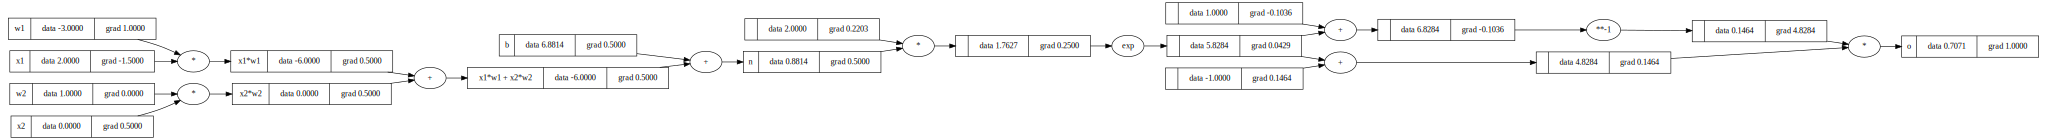

In [16]:
draw_dot(o)

In [15]:
o.backward()

In [2]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True


In [3]:
x1.data.item()

2.0